# Predicting the language of life
Created by Hannah-Marie Martiny and Marianne Helenius as part of the course 02456 Deep Learning at the Technical University of Denmark.

The goal is to predict amino acids in a sequence at specific locations either by using the **Continuous Bag-of-Words model** or the **Skip-gram model**. 

# Table of contents
1. [Continuous Bag-of-Words](#cbow)
    1.1 [Training the CBoW model](#cbow_train)
    1.2 [Testing CBoW](#cbow_test)
    1.3 [t-SNE visualization](#cbow_tsne)
2. [Skip-gram](#sg)
    2.1 [Training the Skip-gram model](#sg_train)
    2.2 [Testing Skip-gram](#sg_test)
    2.3 [t-SNE visualization](#sg_tsne)
3. [Evaluating the embeddings of the two networks](#embeddings)
    3.1 [CBoW embedding evaluations](#cbow_embed)
    3.2 [Skip-gram embedding evaluations](#sg_embed)

# 1. Continuous Bag-of-Words (CBoW)
<a id="cbow"></a>
Written by: Marianne Helenius

## 1.1 Training the CBoW model
<a id="cbow_train"></a>
To run the CBOW model in a terminal, write
```console
python CBoWscripts/main_CBoW_aa.py -train_data TRAIN_DATA -val_data VAL_DATA [OPTIONAL FLAGS]
```
The CBoW model has been implemented to run through command line with the following flags used in the run below: 
* `-train_data TRAIN_DATA`: Path to training data.
* `-val_data VAL_DATA`: Path to validation data.
* `-direction {before,after,both}`: Direction of window, which can be `before`, `after` or `both` for the models $p\left(y_t|y_{t-c}\right)$, $p\left(y_t|y_{t+c}\right)$ and $p\left(y_t|y_{t-c}^{t+c}\right)$, respectively. 
* `-padding`: Whether to use padding on not.
* `-window_size WINDOW_SIZE`: Size of the context window.
* `-batch_size BATCH_SIZE`: Size of neural network batches.
* `-learning_rate LEARNING_RATE`: Learning rate for neural network.
* `-f POST_FIX`Post_fix for output files. 
* `-epochs EPOCHS`: Number of epochs.
* `-embed_dim EMBEDDING_DIM`: Number of embedding dimensions.
* `-resume RESUME`: Filename for saved checkpoint.
* `-wkdir WKDIR`: Path to directory for output files. 

In [1]:
# Set flags and parameters
tr = 'data/proteins.train.txt'
v = 'data/proteins.val.txt'
ws = 10
d_ws = 'both'
bs = 256
emb = 2
post_fix = '_{0}_{1}_lr001_em{2}'.format(d_ws, ws, emb)

# Working directory, where output files will be saved
wkdir = 'data/results/'

In [7]:
# Run CBoW model through command line
!python main_CBoW_aa.py -train_data $tr -val_data $v -direction $d_ws -padding -window_size $ws -batch_size $bs -f $post_fix -learning_rate 0.001 -epochs 50 -embed_dim $emb -wkdir $wkdir


# Loading corpus...
	Done

# Building vocabulary...
	Done

# Making context pairs...
^C


The program above will output the following files: 
* Checkpoints containing model details that can be loaded for testing or if training is resumed with `-r`. These are stored as .pt files. 
* Log files with epoch, loss, perplexity and accuracy. 
* The performance plot for the current number of epochs if traning is not interrupted prematurely.

## 1.2 Testing model
<a id="cbow_test"></a>
The trained model can be tested by running the following notebook section, or through terminal with
```console
python test_cbow.py -model MODEL -test_data TEST_DATA [OPTIONAL FLAGS]
```
as mentioned in the `readme`. 

In [2]:
# Import packages
import CBoW_scripts.functions as f
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import sys
import os
from tqdm import tqdm
import numpy as np

# Set best epoch
check = 46

### Load data

In [3]:
# Load word2idx (was created during training)
word2idx = torch.load('data/word2idx.pt')
print(word2idx)

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20, 'padding': 0}


In [12]:
# Load test data
test_data = f.DataLoader()
test_data.load_corpus(path='data/proteins.test.txt')

# Make context pairs for validation data
test_data.make_context_pairs(window_size=ws, padding=True, direction=d_ws)

# Convert to numpy
test_data.words_to_index(word2idx=word2idx)

# After data has been loaded it is good to check what is looks like. 
print('Number of test samples:\t', test_data.context_array[0].shape)

# Loading corpus...
	Done

# Making context pairs...
	Done

# Converting words to indices...
(19153517, 20)
	Done

Number of test samples:	 (19153517, 20)


In [13]:
# Make batches
test = data_utils.TensorDataset(torch.from_numpy(test_data.context_array[0]), 
                                torch.from_numpy(test_data.context_array[1]))
load_test = data_utils.DataLoader(test, batch_size=bs, shuffle=True)

### Load model to test

In [4]:
# Set up to use GPU if available
use_cuda = torch.cuda.is_available()

In [5]:
# Load net class
net = f.cbow(vocab_size=len(word2idx), embedding_dim=emb, padding=True)

# If GPU is available
if use_cuda:
    print('# Converting network to cuda-enabled')
    net.cuda()
    loc_map = None
else: 
    loc_map='cpu'
print(net)

cbow(
  (embeddings): Embedding(21, 2, padding_idx=0)
  (linear_out): Linear(in_features=2, out_features=21, bias=False)
)


In [6]:
# Set up neural net
net_path = wkdir+'check' + str(check) + post_fix + '.pt'
check = torch.load(net_path, map_location=loc_map)
net.load_state_dict(check['model_state_dict'])
epoch = check['epoch']

# Set criterion 
criterion = nn.CrossEntropyLoss()

### Run test

In [17]:
# Run model on test set
test_acc, test_loss = [], []

### Evaluation ###
net.eval()

test_preds, test_targs = [], []
test_losses, test_accs, test_lengths = 0, 0, 0
examples, n_examples = [], 5

# Print running 
pbar_test = tqdm(load_test, position=0)
pbar_test.set_description("[Epoch {}, test]".format(epoch+1))

for i, (inputs, labels) in enumerate(pbar_test):
    n_samples = inputs.shape[0]

    # Convert targets and input to cuda if available
    if use_cuda: 
        inputs = inputs.cuda()
        labels = labels.cuda()

    # Get predictions
    output = net(inputs)
    preds = torch.max(input=output, dim=1)[1]

    if use_cuda: 
        preds = preds.data.cpu().numpy()
    else: 
        preds = preds.data.numpy()

    # Calculate validation loss
    test_losses += criterion(output, labels).item() * n_samples
    test_accs += f.accuracy(y_true=labels, y_pred=output) * n_samples
    test_lengths += n_samples
    
    # Print percentage run
    pbar_test.set_postfix(loss=test_losses/test_lengths, perp=np.exp(test_losses/test_lengths), acc=test_accs/test_lengths)
print('\n### Test completed!')

[Epoch 46, test]: 100%|██████████| 74819/74819 [08:06<00:00, 153.87it/s, acc=0.102, loss=2.88, perp=17.7]


### Test completed!


In [18]:
# Show results of evaluation
print('# Epoch %2i, TEST: loss=%f, perp=%f, acc=%f\n' % (epoch+1, test_losses/test_lengths, 
                                                         np.exp(test_losses/test_lengths), 
                                                         test_accs/test_lengths))

# Epoch 46, TEST: loss=2.875880, perp=17.741022, acc=0.101615



## 1.3 t-SNE visualization
<a id="cbow_tsne"></a>

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 21 / 21
[t-SNE] Mean sigma: 1.085304
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.359368
[t-SNE] KL divergence after 500 iterations: 0.045773


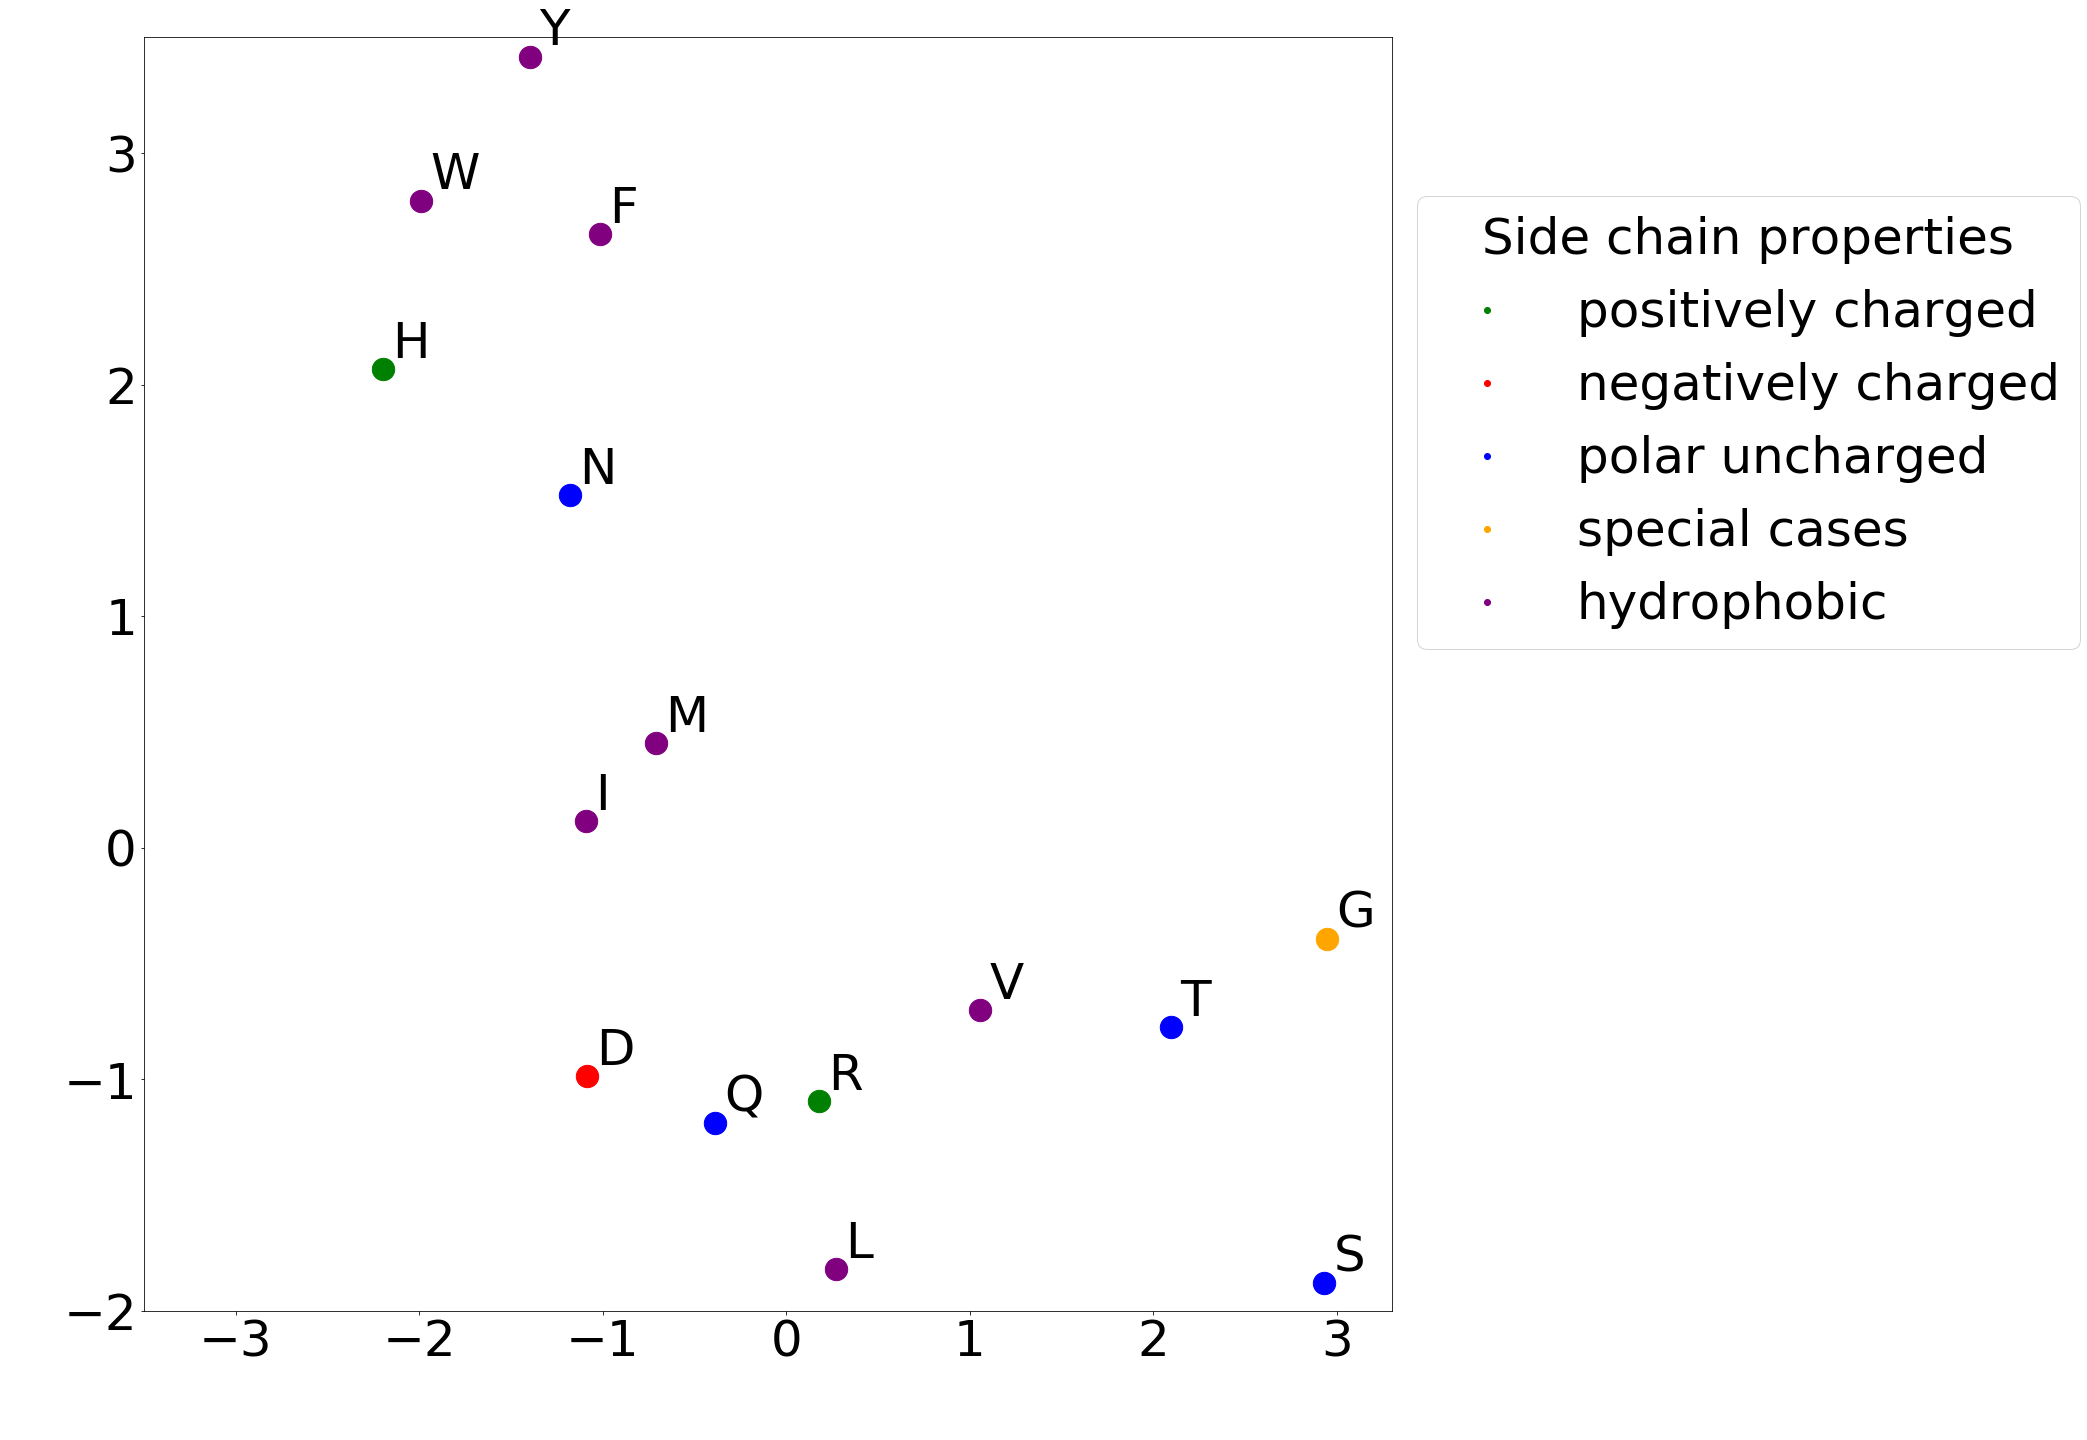

In [22]:
from utils.funcs import plot_tSNE
%matplotlib inline
words = sorted(word2idx, key=word2idx.get, reverse=True)
words_array = np.array(words)

idx2vec = net.embeddings.weight.data.cpu().numpy()

plot_name = 'cbow_'+post_fix+'_tSNE.png'
plot_tSNE(idx2vec=idx2vec, word2idx=word2idx, words=words_array, filename=plot_name)

# 2. Skip-gram
<a id="sg"></a>
Written by: Hannah-Marie Martiny

In [1]:
import torch
import torch.optim as optim
import torch.utils.data as data_utils
import torch.nn as nn

import numpy as np

from utils.data_process import Preprocess
from model.skipgram import SkipGram
from utils.funcs import plot_tSNE

## 2.1 Training the Skip-gram model
<a id="sg_train"></a>
This training is also implemented as a command line program and can be run with the following arguments:
- `--datadir DATADIR`: data directory
- `--traindata TRAINDATA`: name for training data file
- `--testdata TESTDATA`: name for test data file
- `--validdata VALIDDATA`: name for validation data file
- `--window WINDOW`: number of surrounding words (context size)
- `--direction {forward,backward,both}`: specifies whether the words forward, backward or both
- `--embeddingdim EMBEDDINGDIM`: number of embedding dimensions
- `-lr LR`: learning rate
- `--batchsize BATCHSIZE`: size of batches
- `--epochs EPOCHS`: how many iterations the network should be trained in
- `--subsampling`: whether or not the data should be subsampled
- `--logevery LOGEVERY`: how often during training should results be printed out
- `--optimizer {Adam,SGD}`: which optimizer should be used: Adam or Stochastic Graident Descent (SGD)
- `--testnetwork`: boolean, should the network be tested on the training data?
- `--tSNE`: boolean, should tSNE plot be created?
- `--save`: boolean, save model each epoch

An example of traing a model:

`python main_sg.py --window 5 --direction forward --epochs 50 --optimizer SGD --embeddingdim 2 -lr 1e-2`

## 2.2 Testing Skip-gram
<a id="sg_test"></a>
This is the network that gave the best results when we evaluated the embeddings later on.

This code also exists as a command line program (`python test_network_sg.py`), but here we show the whole code.

In [2]:
# Model parameters
window = 10
direction = 'backward'
optim_func = 'SGD'
lr = 1e-2
embedding_dim = 2

In [3]:
# Load word2idx
with open('data/sg_word2idx.txt') as f:
    word2idx = eval(f.readline())

print(word2idx)

{'_': 21, 'L': 1, 'S': 2, 'E': 3, 'A': 4, 'G': 5, 'V': 6, 'K': 7, 'P': 8, 'T': 9, 'R': 10, 'D': 11, 'Q': 12, 'I': 13, 'N': 14, 'F': 15, 'Y': 16, 'H': 17, 'M': 18, 'C': 19, 'W': 20}


In [4]:
# Load the data
f = open('data/proteins.test.txt', 'r')
preprocess_test = Preprocess(window_size=window, unk='_')
preprocess_test.build(file=f, word2idx=word2idx, direction=direction)
f.close()

Creating vocab
Done with building vocab
Converting corpus..
Done


In [5]:
# setup the network
net = SkipGram(embedding_dim=2, vocab_size=preprocess_test.vocab_size+1)

In [6]:
# create iterator for batches
test_loader = data_utils.DataLoader(preprocess_test.data, batch_size=256, shuffle=True, num_workers=0)

In [7]:
# check if cuda is available
use_cuda = torch.cuda.is_available()    

# read in the model file
model_name = 'data/window_{0}_epoch_50_{1}_{2}_lr{3}_emb{4}_model.pkl'.format(window, direction, 
                                                                              optim_func, lr, embedding_dim)
if use_cuda:
    checkpoint = torch.load(model_name)
else:
    checkpoint = torch.load(model_name, map_location='cpu')
    
# load previously trained weights
net.load_state_dict(checkpoint['model_state_dict'])

In [8]:
test_loss, test_length = 0, 0

N = len(test_loader)
print("Evaluating the model on the test data")
# test loop
for i, (center, contexts) in enumerate(test_loader):
    print("{0}/{1}".format(i+1, N), end='\r')
    center = center.long()
    contexts = contexts.long()

    if use_cuda:
        center = center.cuda()
        contexts = contexts.cuda()

    output = net(center, contexts)

    loss = -output.mean(1).mean()

    test_loss += loss.item() * center.shape[0]
    test_length += center.shape[0]
    
test_loss /= test_length

print("Test loss: {:.3f}, Test perplexity: {:.3f}".format(test_loss, np.exp(test_loss)))

Evaluating the model on the test data
Test loss: 2.303, Test perplexity: 10.000


## 2.3 t-SNE visualization
<a id="sg_tsne"></a>

[t-SNE] Computing pairwise distances...
[t-SNE] Computed conditional probabilities for sample 21 / 21
[t-SNE] Mean sigma: 0.073949
[t-SNE] KL divergence after 250 iterations with early exaggeration: 37.239226
[t-SNE] KL divergence after 500 iterations: 0.058226


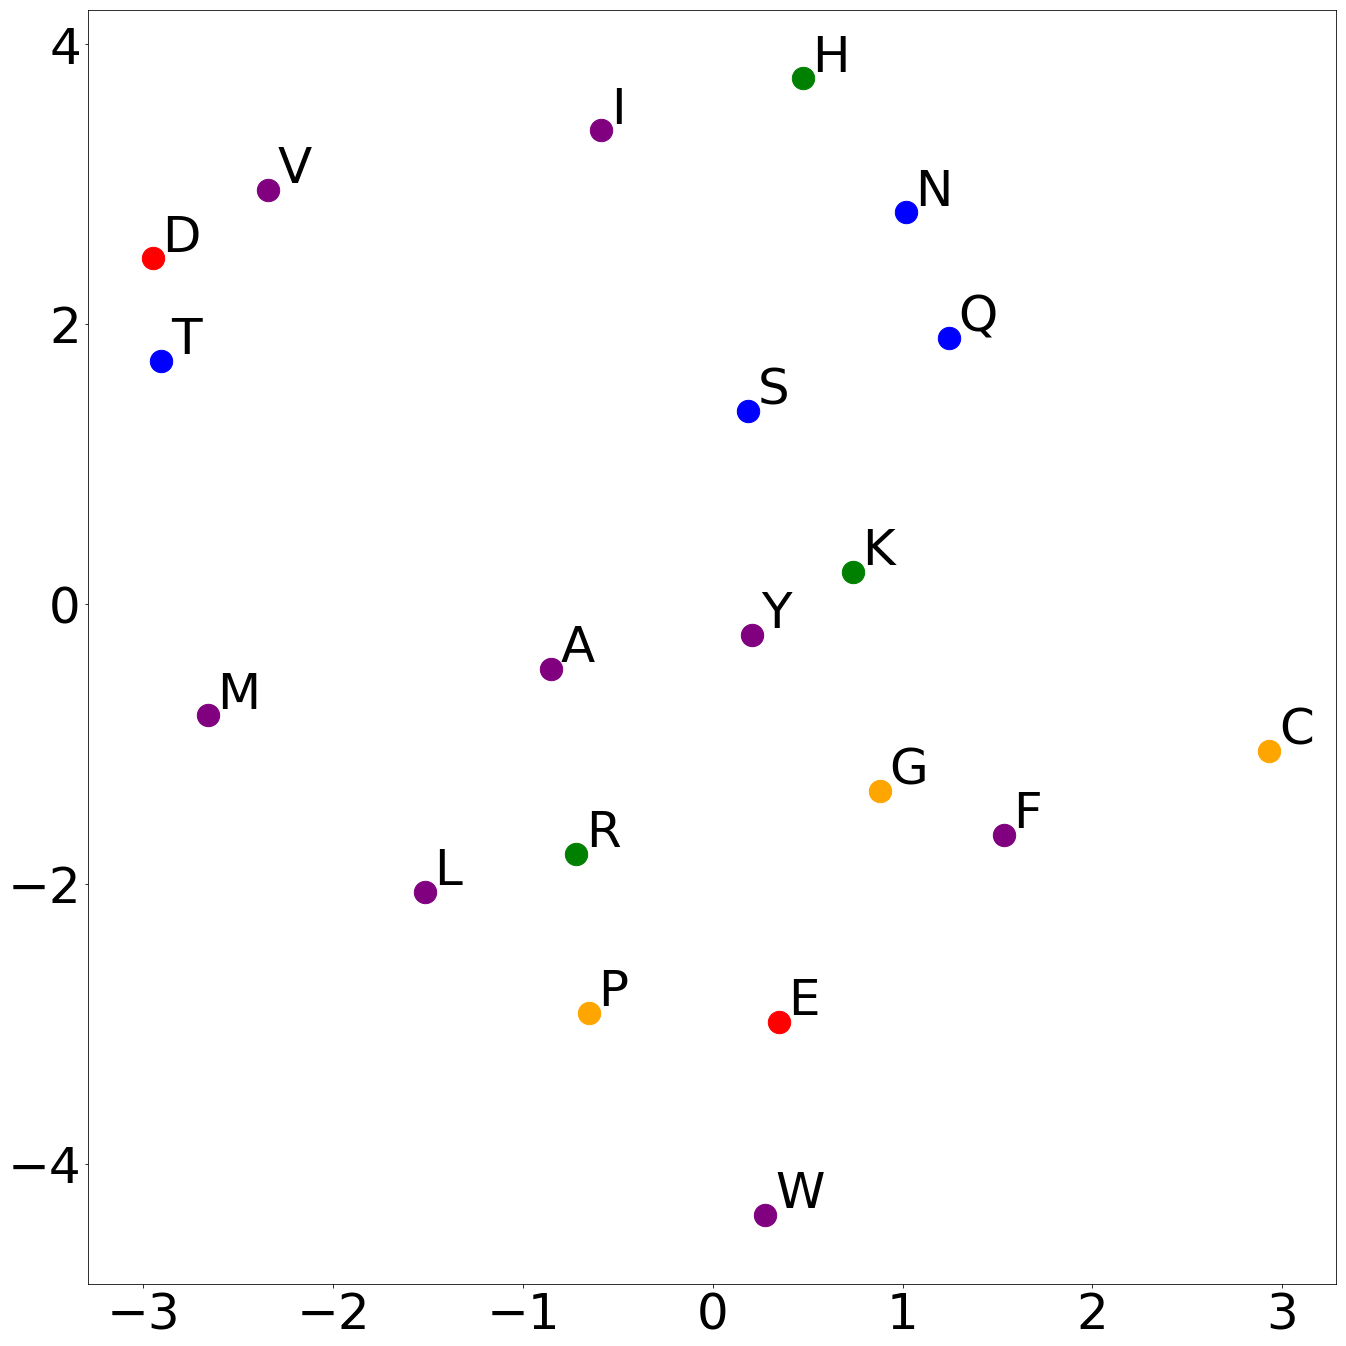

In [17]:
%matplotlib inline
# tSNE plot
# get words / amino acids that are unique
words = sorted(preprocess_test.wc, key=preprocess_test.wc.get, reverse=True)
words_array = np.array(words)

idx2vec = net.in_embedding.weight.data.cpu().numpy()

plot_name = "_".join(model_name.split('_')[:-1]) + '_tSNE.png'
plot_tSNE(idx2vec=idx2vec, word2idx=preprocess_test.word2idx, words=words_array, filename=plot_name)

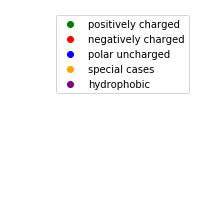

In [45]:
%matplotlib inline
# seperate legend
custom_legend = [plt.Line2D([0], [0], color='green', marker='o', linestyle=''), 
                    plt.Line2D([0], [0], color='red', marker='o', linestyle=''), 
                    plt.Line2D([0], [0], color='blue', marker='o', linestyle=''), 
                    plt.Line2D([0], [0], color='orange', marker='o', linestyle=''), 
                    plt.Line2D([0], [0], color='purple', marker='o', linestyle='')]
coloring_scheme = {'R': 'green', 'H': 'green', 'K': 'green', #positively charged side chains 
                        'D': 'red', 'E': 'red',  #negatively charges side chains
                        'S': 'blue', 'T': 'blue', 'N': 'blue', 'Q': 'blue', #polar uncharged side chains
                        'C': 'orange', 'U': 'orange', 'G': 'orange', 'P': 'orange', # special cases
                        'A': 'purple', 'V': 'purple', 'I': 'purple', 'L': 'purple', 'M': 'purple', 'F': 'purple', 'Y': 'purple', 'W': 'purple', #hydrophobic side chains
                        '_': 'white'}
figsize = (3, 3)
fig_leg = plt.figure(figsize=figsize)
ax_leg = fig_leg.add_subplot(111)
ax_leg.axis('off')
ax_leg.legend(handles=custom_legend, labels=['positively charged', 'negatively charged', 'polar uncharged', 'special cases', 'hydrophobic'])
plt.tight_layout()
plt.show()

# 3. Evaluating the embeddings from the two networks
<a id="embeddings"></a>
Written by: Hannah-Marie Martiny and Marianne Helenius

The embeddings are evaluated by comparing BLOSUM62 scores, embedding similarity and analogical reasoning. 

In [7]:
from analogical_reasoning import *

## 3.1 CBoW embedding evaluations
<a id="cbow_embed"></a>

In [8]:
# Load net class
net = f.cbow(vocab_size=len(word2idx), embedding_dim=2, padding=True)

# If GPU is available
if use_cuda:
    print('# Converting network to cuda-enabled')
    net.cuda()
    loc_map = None
else: 
    loc_map='cpu'
print(net)

cbow(
  (embeddings): Embedding(21, 2, padding_idx=0)
  (linear_out): Linear(in_features=2, out_features=21, bias=False)
)


In [9]:
# Set up neural net
net_path = wkdir+'check' + str(46) + post_fix + '.pt'
check = torch.load(net_path, map_location=loc_map)
net.load_state_dict(check['model_state_dict'])
epoch = check['epoch']

In [10]:
# Make idx2word
idx2word = {value: key for key, value in word2idx.items()}
print(idx2word)

{1: 'A', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'K', 10: 'L', 11: 'M', 12: 'N', 13: 'P', 14: 'Q', 15: 'R', 16: 'S', 17: 'T', 18: 'V', 19: 'W', 20: 'Y', 0: 'padding'}


In [11]:
# Get embeddings
idx2vec = net.embeddings.weight.data.cpu()

### BLOSUM62 comparison

In [12]:
correct_blosum62, n = 0, 0
for aa in range(1, len(idx2word)):
    score, ns = compare_blosum62(idx2vec, idx2word, aa, k=3, verbose=True)
    if isinstance(score, int):
        correct_blosum62 += score
        n += ns

print("Blosum62 comparison with k nearest neighbors to each amino acid\nAccuracy:", correct_blosum62/n)


Top 3 closest words to A
Blosum62 score for ('S', 'A'): 1
Blosum62 score for ('A', 'A'): 4
Blosum62 score for ('E', 'A'): -1
Top 3 blosum62 scores with A
('A', 'A'): 4
('S', 'A'): 1
('V', 'A'): 0

Top 3 closest words to C
Blosum62 score for ('C', 'C'): 9
Blosum62 score for ('Y', 'C'): -2
Blosum62 score for ('W', 'C'): -2
Top 3 blosum62 scores with C
('C', 'C'): 9
('C', 'A'): 0
('S', 'C'): -1

Top 3 closest words to D
Blosum62 score for ('E', 'D'): 2
Blosum62 score for ('K', 'D'): -1
Blosum62 score for ('D', 'A'): -2
Top 3 blosum62 scores with D
('D', 'D'): 6
('B', 'D'): 4
('E', 'D'): 2

Top 3 closest words to E
Blosum62 score for ('E', 'E'): 5
Blosum62 score for ('K', 'E'): 1
Blosum62 score for ('E', 'A'): -1
Top 3 blosum62 scores with E
('E', 'E'): 5
('Z', 'E'): 4
('E', 'D'): 2

Top 3 closest words to F
Blosum62 score for ('F', 'C'): -2
Blosum62 score for ('Y', 'F'): 3
Blosum62 score for ('W', 'F'): 1
Top 3 blosum62 scores with F
('F', 'F'): 6
('Y', 'F'): 3
('W', 'F'): 1

Top 3 close

### Embedding similarity

In [13]:
for aa in range(1, len(idx2word)):
    most_similar(idx2vec, idx2word, aa)

Most similar word to A: S with probability 8.510
Most similar word to C: C with probability 1.973
Most similar word to D: E with probability 4.873
Most similar word to E: E with probability 10.464
Most similar word to F: C with probability 0.151
Most similar word to G: P with probability 5.697
Most similar word to H: P with probability 0.819
Most similar word to I: E with probability 3.128
Most similar word to K: E with probability 8.012
Most similar word to L: E with probability 5.677
Most similar word to M: E with probability 2.687
Most similar word to N: E with probability 1.298
Most similar word to P: P with probability 8.779
Most similar word to Q: E with probability 4.915
Most similar word to R: E with probability 4.854
Most similar word to S: S with probability 9.263
Most similar word to T: S with probability 5.413
Most similar word to V: S with probability 4.104
Most similar word to W: C with probability 0.253
Most similar word to Y: C with probability 0.688


### Analogical reasoning

In [14]:
with open('data/analogical_reasoning.txt', 'r') as f:
    n = 0
    correct = 0
    for line in f.readlines():

        # skip comment lines
        if line[0] != '#':
            n += 1
            w1, w2, w3, w4 = line.strip('\n').split(' ')
            correct += eval_analogies(idx2vec, idx2word, word2idx[w1], word2idx[w2], word2idx[w3], word2idx[w4], verbose=True)

    print("Accuracy for analogical reasoning: {:.3f}".format(correct/n))

Predicted analogy:
D is to E, as Q is to E
Expected analogy:
D is to E, as Q is to N

Predicted analogy:
D is to E, as S is to A
Expected analogy:
D is to E, as S is to T

Predicted analogy:
R is to K, as N is to E
Expected analogy:
R is to K, as N is to Q

Predicted analogy:
M is to L, as V is to A
Expected analogy:
M is to L, as V is to I

Predicted analogy:
K is to R, as S is to P
Expected analogy:
K is to R, as S is to T

Predicted analogy:
E is to D, as M is to C
Expected analogy:
E is to D, as M is to L

Predicted analogy:
S is to T, as G is to P
Expected analogy:
S is to T, as G is to P

Accuracy for analogical reasoning: 0.143


## 3.2 Skip-gram embedding evaluations
<a id="sg_embed"></a>

In [13]:
# load in idx2word
with open('data/sg_idx2word.txt', 'r') as f:
    idx2word = eval(f.readline())

In [16]:
# embedding matrix
idx2vec = net.in_embedding.weight.data.cpu()

### BLOSUM62 comparison

In [23]:
correct_blosum62, n = 0, 0
for aa in range(1, len(idx2word)):
    score, ns = compare_blosum62(idx2vec, idx2word, aa, k=3, verbose=True)
    if isinstance(score, int):
        correct_blosum62 += score
        n += ns

print("Blosum62 comparison with k nearest neighbors to each amino acid\nAccuracy:", correct_blosum62/n)


Top 3 closest words to L
Blosum62 score for ('L', 'Q'): -2
Blosum62 score for ('L', 'I'): 2
Blosum62 score for ('L', 'L'): 4
Top 3 blosum62 scores with L
('L', 'L'): 4
('M', 'L'): 2
('L', 'I'): 2

Top 3 closest words to S
Blosum62 score for ('S', 'Q'): 0
Blosum62 score for ('S', 'M'): -1
Top 3 blosum62 scores with S
('S', 'S'): 4
('S', 'N'): 1
('S', 'A'): 1

Top 3 closest words to E
Blosum62 score for ('E', 'Q'): 2
Blosum62 score for ('I', 'E'): -3
Blosum62 score for ('L', 'E'): -3
Top 3 blosum62 scores with E
('E', 'E'): 5
('Z', 'E'): 4
('E', 'D'): 2

Top 3 closest words to A
Blosum62 score for ('P', 'A'): -1
Blosum62 score for ('H', 'A'): -2
Blosum62 score for ('A', 'A'): 4
Top 3 blosum62 scores with A
('A', 'A'): 4
('S', 'A'): 1
('V', 'A'): 0

Top 3 closest words to G
Blosum62 score for ('M', 'G'): -3
Blosum62 score for ('F', 'G'): -3
Top 3 blosum62 scores with G
('G', 'G'): 6
('G', 'N'): 0
('S', 'G'): 0

Top 3 closest words to V
Blosum62 score for ('V', 'Q'): -2
Blosum62 score for

### Embedding similarity

In [19]:
for aa in range(1, len(idx2word)):
    most_similar(idx2vec, idx2word, aa)

Most similar word to L: Q with probability 0.034
Most similar word to S: _ with probability 0.005
Most similar word to E: Q with probability 0.018
Most similar word to A: P with probability 0.028
Most similar word to G: _ with probability 0.005
Most similar word to V: Q with probability 0.030
Most similar word to K: Q with probability 0.023
Most similar word to P: P with probability 0.066
Most similar word to T: P with probability 0.018
Most similar word to R: W with probability 0.006
Most similar word to D: P with probability 0.024
Most similar word to Q: Q with probability 0.058
Most similar word to I: Q with probability 0.040
Most similar word to N: _ with probability 0.012
Most similar word to F: P with probability 0.009
Most similar word to Y: W with probability 0.019
Most similar word to H: P with probability 0.060
Most similar word to M: _ with probability 0.034
Most similar word to C: H with probability 0.026
Most similar word to W: W with probability 0.030
Most similar word to

### Analogical reasoning

In [21]:
with open('data/analogical_reasoning.txt', 'r') as f:
    n = 0
    correct = 0
    for line in f.readlines():

        # skip comment lines
        if line[0] != '#':
            n += 1
            w1, w2, w3, w4 = line.strip('\n').split(' ')
            correct += eval_analogies(idx2vec, idx2word, word2idx[w1], word2idx[w2], word2idx[w3], word2idx[w4], verbose=True)

    print("Accuracy for analogical reasoning: {:.3f}".format(correct/n))

Predicted analogy:
D is to E, as Q is to Q
Expected analogy:
D is to E, as Q is to N

Predicted analogy:
D is to E, as S is to Q
Expected analogy:
D is to E, as S is to T

Predicted analogy:
R is to K, as N is to Q
Expected analogy:
R is to K, as N is to Q

Predicted analogy:
M is to L, as V is to Q
Expected analogy:
M is to L, as V is to I

Predicted analogy:
K is to R, as S is to P
Expected analogy:
K is to R, as S is to T

Predicted analogy:
E is to D, as M is to P
Expected analogy:
E is to D, as M is to L

Predicted analogy:
S is to T, as G is to P
Expected analogy:
S is to T, as G is to P

Accuracy for analogical reasoning: 0.286
